In [13]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import time
import os
from tqdm import tqdm
from scipy.interpolate import CubicSpline
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
plt.style.use('dark_background')

In [14]:
## 将VIN车况按照时间连续性分段
def slice_by_gap(df, threshold):
    time_gap = df.index.to_series().diff()
    mask = time_gap > pd.Timedelta(threshold)
    group_num = mask.cumsum()
    return group_num

# 插值填充数据
def fill_in(df_raw):
    # 将车速、发动机净输出扭矩、发动机转速三列转为float格式
    for column in ["speed", 'ftorque', 'rpm']:
        df_raw[column] = df_raw[column].astype(float)

    # 创建一个完整时间范围的DataFrame，从原始数据的开始到结束，频率为每秒。
    full_time_span = pd.date_range(start=df_raw.index[0], end=df_raw.index[-1], freq='S')
    df = df_raw.reindex(full_time_span)

    window = 5  # 定义滑动窗口的大小

    # 将时间戳转换为相对秒数，以便于插值计算
    time_zero = df.index[0]
    df['seconds'] = (df.index - time_zero).total_seconds()

    # 为了缓存并减少重复计算，获取数据框的长度
    df_length = len(df)

    # 存储用于插值的数据片段
    xs = []

    # 为以下列进行插值填充
    columns_to_fill = ["speed", 'ftorque', 'rpm']

    for col in columns_to_fill:
        # 定位缺失数据的索引
        missing_indices = df[df[col].isnull()].index

        # 对每一个缺失的数据点进行处理
        for missing_idx in missing_indices:
            idx_location = df.index.get_loc(missing_idx)
            start = max(0, idx_location - window // 2)
            end = min(df_length, idx_location + window // 2 + 1)

            # 确保至少有3个非空值来进行插值
            while df[col].iloc[start:end].notnull().sum() < 3:
                start = max(0, start - 1)
                end = min(df_length, end + 1)

            # 获取有效的、非空的数据片段用于插值
            valid_data = df[['seconds', col]].iloc[start:end].dropna()

            # 使用三次样条插值计算缺失的值
            cs = CubicSpline(valid_data['seconds'], valid_data[col])
            interp_val = cs((missing_idx - time_zero).total_seconds())

            # 确保插值后的结果不是负数
            interp_val = max(0, interp_val)

            df.at[missing_idx, col] = float(interp_val)  # 转换为浮点数确保是标量值

            # 将用于插值的数据片段添加到xs列表中
            xs.append(valid_data)

    # 插值完成后，删除"seconds"列
    df = df.drop('seconds', axis=1)

    return df, xs


# 根据时长分段
def split_segments_by_time(segments):
    new_segments = []
    for seg in segments:
        start, end = seg

        # 获取这个段的总长度
        segment_length = end - start + 1

        # 当这个段的长度超过10秒时，我们将它分割为10秒的子段
        while segment_length > 10:
            new_segments.append((start, start + 9))  # 10秒的子段
            start += 10
            segment_length = end - start + 1

        # 添加剩下的部分，它的长度将介于1到10秒之间
        if segment_length > 0:
            new_segments.append((start, end))

    return new_segments


# 提取标号并拆分那些在给定阈值下连续且恒定的片段
def extract_constant_seg(full_array, threshold):
    # 初始化保存恒定片段的列表和起始索引
    segments = []
    start_index = 0

    # 遍历数组
    for i in range(1, len(full_array)):
        # 当遇到不等于起始值的元素时
        if full_array[i] != full_array[start_index]:
            # 如果连续片段的长度达到了阈值
            if i - start_index >= threshold:
                # 将此片段的起始和结束索引添加到segments列表中
                segments.append((start_index, i - 1))
            # 更新起始索引为当前元素索引
            start_index = i

    # 如果数组最后一段的长度达到阈值
    if len(full_array) - start_index >= threshold:
        segments.append((start_index, len(full_array) - 1))

    # 将得到的segments切成10s段并返回
    return split_segments_by_time(segments)
#     return segments

# 在输入数组中找到恒定加速度的片段
def extract_const_acc(full_array, threshold):
    # 计算数组元素之间的差值，这用于检测加速度的变化
    arr_diff = np.diff(full_array)
    # 使用之前定义的函数提取恒定差值的片段
    cnst_acc = extract_constant_seg(arr_diff, threshold - 1)
    # 调整片段的结束索引
    cnst_acc = [(x[0], x[1] + 1) for x in cnst_acc]
    return cnst_acc


# 找到未被给定恒定片段覆盖的部分并存储
def sans_constant(input_list, index_pairs):
    uncovered_pairs = []
    start = 0

    # 遍历所有恒定片段
    for pair in index_pairs:
        # 如果当前片段的开始与前一片段的结束之间存在间隔
        if start != pair[0]:
            # 记录这个间隔片段
            uncovered_pairs.append((start, pair[0] - 1))
        # 更新起始索引为当前片段的结束索引+1
        start = pair[1] + 1

    # 如果列表的最后部分未被覆盖，将其添加到未被覆盖的片段中
    if start < len(input_list):
        uncovered_pairs.append((start, len(input_list) - 1))

    return uncovered_pairs


# 将恒定片段和未覆盖片段合并为一个字典，并为它们分配标志（恒定为0，非恒定为1），最后根据起始索引进行排序
def sort_all_seg_pair(constant_segments, left_segments):
    # 使用字典推导式直接为两种片段添加标签
    # 匀速片段标记为0，易变片段标记为1
    combined_dict = {pair: 0 for pair in constant_segments}
    combined_dict.update({pair: 1 for pair in left_segments})

    # 根据片段的起始索引进行排序
    combined_sorted_dict = dict(sorted(combined_dict.items(), key=lambda item: item[0]))

    # 返回排序后的标记过的片段字典
    return combined_sorted_dict

#
def constant_segment_processing(velo_array, constant_threshold):
    # 提取恒定加速度的片段
    constant_segments = extract_const_acc(velo_array, constant_threshold)
    # 获取除恒定加速度片段以外的其他片段
    left_segments = sans_constant(velo_array, constant_segments)
    # 将两种片段合并并按照起始索引排序
    all_pairs_sorted = sort_all_seg_pair(constant_segments, left_segments)
    return all_pairs_sorted


# 删除flag为1的标志
def split_volatile_segments(results_dict):
    modified_dict = results_dict.copy()

    for seg, flag in results_dict.items():
        if flag == 1:
            # 删除原始段
            del modified_dict[seg]
            # 使用split_segments_by_time函数来分割段
            splits = split_segments_by_time([seg])
            # 将分割后的段添加到字典中
            for split in splits:
                modified_dict[split] = 1

    return modified_dict


# 寻找加速度变化率
def find_jerk_std(velocity):
    # 通过对速度列表进行逐项相减，得到加速度列表
    acceleration = np.array(velocity[:-1]) - np.array(velocity[1:])

    # 通过对加速度列表进行逐项相减，得到jerk列表
    jerk = acceleration[:-1] - acceleration[1:]

    # 计算jerk列表的标准差
    jerk_std = np.std(jerk)

    # 返回jerk的标准差
    return jerk_std


# 定义卡尔曼滤波函数
def Kalman_Filter(meas_speed, std_jerk):
    ## 1. 初始化参数
    # 观测的时间单位
    dt = 1
    # 控制因子
    u = 0
    # 测量速度的标准差
    std_meas = np.std(meas_speed)

    ## 2. 初始化矩阵
    # 初始化状态转移矩阵 A 和控制矩阵 B
    A = np.matrix([[1, dt], [0, 1]])
    B = np.matrix([[(dt ** 2 / 2)], [dt]])
    # 初始化测量矩阵 H
    H = np.matrix([[1, 0]])

    ## 3. 初始化噪声协方差矩阵
    # 过程噪声协方差矩阵，由加速度的标准差计算得到 Q
    Q = np.matrix([[(dt ** 4) / 4, dt ** 3 / 2],
                   [(dt ** 3 / 2), dt ** 2]]) * std_jerk ** 2
    # 初始化噪声方差
    R = std_meas ** 2
    # 初始化协方差矩阵 P
    P = np.eye(A.shape[1])
    
    ## 4. 初始化向量 x
    x = np.matrix([[meas_speed[0]], [(meas_speed[1] - meas_speed[0])]])

    ## 5. 卡尔曼滤波循环
    predictions = []
    for i in range(len(meas_speed)):
        # Prediction
        x = np.dot(A, x) + np.dot(B, u)
        P = np.dot(np.dot(A, P), A.T) + Q

        # Update
        S = np.dot(H, np.dot(P, H.T)) + R
        K = np.dot(np.dot(P, H.T), inv(S))
        z = meas_speed[i]
        x = np.round(x + np.dot(K, (z - np.dot(H, x))))
        predictions.append(x)
        I = np.eye(H.shape[1])
        P = (I - (K * H)) * P

    ## 6. 最终预测结果：速度
    final_predictions = [x[0] for x in np.squeeze(predictions)]
    ## 返回预测结果
    return final_predictions


# 速度预测信号中的极大值点、极小值点
def signal_extremes(kalman_predictions, prominence):
    # 使用 find_peaks 函数和提升度参数找到所有的极大值点的索引
    maxima, _ = find_peaks(kalman_predictions, prominence=prominence)

    # 将速度预测信号取负，然后找到所有的极大值点，这些点在原始信号中就是极小值点
    minima, _ = find_peaks([-x for x in kalman_predictions], prominence=prominence)

    # 将找到的极大值点和极小值点的索引合并，并按照升序排序
    extremes_index = list(np.sort(np.concatenate([maxima, minima])))

    # 在排序后的索引列表的开始和结束处插入两个特殊的索引：0和len(kalman_predictions)-1，这两个索引表示滤波后的速度预测信号的开始和结束点
    extremes_index.insert(0, 0)
    extremes_index.append(len(kalman_predictions) - 1)

    # 返回索引列表，这些索引表示了速度预测信号中的极大值点、极小值点和开始结束点
    return extremes_index

# 对于给定的分段索引对字典，根据不同的段性质进行不同的处理，并最终返回一个包含所需索引的列表。
def index_processing(seg_index_pairs, volatile_threshold, meas_speed):
    # 初始化结果索引列表
    result_idxs = []

    # 遍历输入的索引对字典
    for k, v in seg_index_pairs.items():
        # 如果当前段是匀速的
        if v == 0:
            # 将当前段的开始和结束点的索引加入到结果索引列表中
            result_idxs.append([k[0]])
            result_idxs.append([k[1]])
        # 如果当前段是变速的
        elif v == 1:
            # 如果当前段的长度小于阈值
            if (k[1] - k[0]) < volatile_threshold:
                # 将当前段的开始和结束点的索引加入到结果索引列表中
                result_idxs.append([k[0]])
                result_idxs.append([k[1]])
            # 如果当前段的长度大于等于阈值
            else:
                # 计算当前段的加速度的标准差
                jerk = find_jerk_std(meas_speed[k[0]:(k[1]+1)])
                # 使用卡尔曼滤波处理当前段
                k_output = Kalman_Filter(meas_speed[k[0]:(k[1]+1)], jerk)
                # 找到滤波后的速度预测中的极大值和极小值点
                sig_output = signal_extremes(k_output, np.std(meas_speed[k[0]:(k[1]+1)])/8)
                # 将这些点的索引（需要加上当前段的开始索引）加入到结果索引列表中
                result_idxs.append([x + k[0] for x in sig_output])

    # 返回结果索引列表
    return result_idxs


# 对时间、速度、加速度等数据进行整理总结
def segment_stats(index_output, time, velo, gas, current_torque, current_rpm, vin, power_df):
    '''
    定义一个名为 segment_stats 的函数，接受参数：
    index_output：包含分段索引的列表
    time：包含时间点信息的列表
    velo：包含速度信息的列表
    gas：包含燃油消耗信息的列表
    current_torque: 一个列表，包含每个时间点的当前扭矩值
    current_rpm: 一个列表，包含每个时间点的当前转速
    car_type: 字符串，表示车辆的类型
    vin: 字符串，表示车辆的识别码
    power_df: 一个DataFrame，包含与车辆相关的功率数据，例如最大净扭矩
    Type: 字符串，表示车型
    '''
    # 如果最后一个索引值等于速度列表的长度，则将其修正为速度列表长度减一
    if index_output[-1] == len(velo):
        index_output[-1] = len(velo) - 1

    # 提取每个分段的开始时间和开始速度
    seg_time = [time[i] for i in index_output]
    seg_velo = [velo[i] for i in index_output]

    # 计算每个分段的时间和速度差，用于后续计算平均加速度
    time_diff = list(np.array(index_output[1:]) - np.array(index_output[:-1]))
    velo_diff = list(np.array(seg_velo)[1:] - np.array(seg_velo[:-1]))
    acc = list(np.divide(velo_diff, time_diff))  # 计算每个分段的平均加速度

    # 初始化用于存储每个分段燃油消耗总量的列表
    gas_consumption = []
    for i in range(len(index_output) - 1):
        seg_gas_consump = np.array(gas[index_output[i]:index_output[i + 1]])

        # 如果当前分段的燃油消耗信息全为 NaN，则将 seg_gas_consump 设置为 0
        if pd.isna(seg_gas_consump).all():
            seg_gas_consump = np.array([0])
        else:
            # 否则，将 NaN 值替换为当前分段的燃油消耗的平均值
            valid_values = seg_gas_consump[~pd.isna(seg_gas_consump)]
            seg_gas_consump[pd.isna(seg_gas_consump)] = np.mean(valid_values)

        seg_gas_total = np.sum(seg_gas_consump)
        seg_gas_total = "{:.2f}".format(seg_gas_total)
        gas_consumption.append(seg_gas_total)
    
    # 将结果整理成 DataFrame 表格并返回
    df_seg = pd.DataFrame(list(zip(seg_time[:-1], seg_velo[:-1], time_diff, acc, gas_consumption)),
                          columns=["start_time", "start_velocity", "time_duration(s)", "acceleration",
                                   "gas_consumption"])

    # df_seg['类型'] = car_type
    df_seg['vin'] = vin
    # df_seg['车型'] = Type

    # 获取最大净扭矩
    max_torque = power_df[power_df['编号']==vin]['最大净扭矩'].iloc[0]

    powers = []  # 用于存储每个子段的平均功率
    for i in range(len(index_output) - 1):
        segment_torque = current_torque[index_output[i]:index_output[i + 1]]
        segment_rpm = current_rpm[index_output[i]:index_output[i + 1]]
        # max_torque = power_df.loc[vin, '最大净扭矩']
        power_values = segment_torque * max_torque * segment_rpm / 955000

        #         # 打印相关数据
        #         if power_values.mean() < 0: # 只在功率为负时打印，以减少输出量
        #             print(f"For segment {i}:")
        #             print(f"Segment Torque: {segment_torque}")
        #             print(f"Segment RPM: {segment_rpm}")
        #             print(f"Max Torque: {max_torque}")
        #             print(f"Power Values: {power_values}")
        #             print("---------------")

        avg_power = power_values.mean()
        powers.append(avg_power)

    df_seg['平均功率'] = powers

    return df_seg

# 对时间，速度进行画图
def plot_segments(arr_time, arr_velocity, segment_index, seg_num):
    plt.figure(figsize = [28,14])
    plt.title(f'Segmentation of OBD velocity data:{seg_num}', fontsize=50)
    plt.plot(arr_time, arr_velocity, label = "Measured Velocity")
#     plt.plot(arr_time, arr_velocity,'s', label = "Measured Data Point")
    # Fix the issue of the ending index number
    if segment_index[-1] == len(arr_velocity):
        segment_index[-1] = len(arr_velocity)-1
    plt.plot([arr_time[x] for x in segment_index],
              [arr_velocity[x] for x in segment_index],
             label = "Filtered Segments")
    plt.plot([arr_time[x] for x in segment_index],
              [arr_velocity[x] for x in segment_index],
            's', label = "Filtered points")
    plt.xlabel('Time')
    plt.ylabel('Speed')
    plt.legend(fontsize=30)
    plt.show()
    # 读取xlsx文件
    power_df = pd.read_csv(r"C:\Users\13244\Desktop\辆车信息.csv", encoding='utf-8-sig')
    # 设置VIN为索引，这样可以方便地根据VIN查找对应的最大净扭矩
    power_df.set_index('VIN', inplace=True)


# 对文件进行处理、分割、统计、保存
def process_file(file_path, output_folder, power_df):
    try:
        df_vin = pd.read_parquet(file_path)
        # car_type = df_vin["类型"][0]
        vin = df_vin["VIN"][0]
        # Type = df_vin["车辆型号"][0]
        df_vin = df_vin[["VIN", "collect_time", "speed", "fuelflow", 'ftorque', 'rpm']]
        df_vin = df_vin.drop_duplicates("collect_time")
        
        count = slice_by_gap(df_vin, '2s')
        
        df_velo_acc = []
        count_df = 0
        volatile_threshold = 5
        # debug
        print("总段数：", count.max())
        short_group_count = 0
        short_group_len = 0

        # enumerate segments
        for df_name, df in df_vin.groupby(count):
            # debug
            if df_name % 1000 == 0:
                print("已处理段数：", df_name)
            if len(df) >= 15:
                ## (1) Fill_in NAs (duration less than 3 seconds)
                df, xs = fill_in(df)
                # debug
                # print("(1)complete")
                
                ## (2) Get velocity and time data from the segments
                current_time = np.array(df.index)
                current_velo = np.array(df["speed"])
                current_gas_inject = np.array(df["fuelflow"])
                current_torque = np.array(df["ftorque"])
                current_rpm = np.array(df["rpm"])
                # debug
                # print("(2)complete")

                ## (3) Continuity segmentation
                segment_pairs = constant_segment_processing(current_velo, volatile_threshold)
                segment_pairs = split_volatile_segments(segment_pairs)
                # debug
                # print("(3)complete")
                
                ## (4) Slice into sub-segments --- based on consecutively constant span, with threshold of 5 or more
                segment_indexes = index_processing(segment_pairs, 5, current_velo)                
                segment_indexes = [x for y in segment_indexes for x in y]
                segment_indexes = list(set(segment_indexes))
                segment_indexes.sort()
                # debug
                # print("(4)complete")

                ## (5) Extract Needed Results
                stats_result = segment_stats(segment_indexes, current_time, current_velo, current_gas_inject,
                                             current_torque, current_rpm, vin, power_df)
                # debug
                # print("(5)complete")

                ## (6) Save info from this segment
                stats_result["segment_index"] = count_df
                df_velo_acc.append(stats_result)
                count_df += 1
                # debug
                # print("(6)complete")
            # debug
            else:
                short_group_count += 1
                short_group_len += len(df)


        if df_velo_acc:  # 如果列表不为空
            final_output = pd.concat(df_velo_acc)
            output_path = os.path.join(output_folder, os.path.basename(file_path)+"-滤波")
            final_output.to_parquet(output_path)
        # debug
        print("短于15的分段数量：", short_group_count, "短于15的分段总长：", short_group_len)

    except Exception as e:
        print(f"Skipping file {os.path.basename(file_path)} due to error: {e}")
        error_files.append(file_path)

In [15]:
def main():
    input_folder = r"/Users/lizhiting/Desktop/Intern/2.Zhihui_Lvxing/2.OBD/OBD原始数据"  # 这里输入您的原始文件夹路径
    output_folder = r"/Users/lizhiting/Desktop/Intern/2.Zhihui_Lvxing/2.OBD/OBD导入数据"  # 这里输入您希望保存处理后文件的文件夹路径
    power_df = pd.read_excel(r"/Users/lizhiting/Desktop/Intern/2.Zhihui_Lvxing/2.OBD/静态信息to ZHLX.xlsx", sheet_name='场景分析', dtype={'编号': str})
    error_files = []

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    files = [f for f in os.listdir(input_folder) if f.endswith('.parquet')]
    for file_name in tqdm(files, desc="Processing files"):
        file_path = os.path.join(input_folder, file_name)
        output_path = os.path.join(output_folder, os.path.basename(file_path))

        # 如果输出文件夹中已经存在这个文件，那么跳过处理
        if os.path.exists(output_path):
            #             print(f"File {file_name} already exists in the output folder. Skipping...")
            continue

        process_file(file_path, output_folder, power_df)

    # 打印出错的文件路径列表（如前所述）
    if error_files:
        print("\nThe following files encountered errors:")
        for error_file in error_files:
            print(error_file)


main()
# final_output, fill_in_vals = main()
# final_output["time_duration(s)"].unique()
# final_output[final_output["平均功率"] < 0]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/lizhiting/Desktop/Intern/2.Zhihui_Lvxing/2.OBD/静态信息to ZHLX.xlsx'

In [ ]:
#TODO
# (Y) 更改输出文件名
# () 
# () 

### 检查输出

In [ ]:
output_0161 = pd.read_parquet(r"/Users/lizhiting/Desktop/Intern/2.Zhihui_Lvxing/2.OBD/OBD导入数据/0161.parquet-滤波")

print(len(output_0161))
print(output_0161['time_duration(s)'].mean())
print(309939*4.8114)
print(output_0161['segment_index'].max())
print(output_0161['segment_index'].nunique())

output_0161

1248777
5.283502178531475
1491240.5045999999
93496
93497


,start_time,start_velocity,time_duration(s),acceleration,gas_consumption,vin,平均功率,segment_index
0,2023-01-02 12:01:10,0.000,10,0.000000,42.75,0161,11.826203,0
1,2023-01-02 12:01:20,0.000,10,0.000000,41.15,0161,11.547361,0
2,2023-01-02 12:01:30,0.000,10,0.000000,40.35,0161,10.628889,0
3,2023-01-02 12:01:40,0.000,10,0.000000,39.50,0161,10.572100,0
4,2023-01-02 12:01:50,0.000,10,0.000000,38.55,0161,10.516749,0
...,...,...,...,...,...,...,...,...
31,2023-12-28 15:54:10,2.863,9,-0.021667,26.05,0161,8.456610,93496
32,2023-12-28 15:54:19,2.668,1,-0.031000,2.50,0161,7.491836,93496
33,2023-12-28 15:54:20,2.637,9,-0.293000,16.48,0161,6.307653,93496
34,2023-12-28 15:54:29,0.000,1,0.000000,1.25,0161,5.624268,93496


In [ ]:
df_0271 = pd.read_parquet(r"/Users/lizhiting/Desktop/Intern/2.Zhihui_Lvxing/2.OBD/OBD导入数据/0271.parquet-滤波")
print(len(df_0271))

output_0271 = pd.read_parquet(r"/Users/lizhiting/Desktop/Intern/2.Zhihui_Lvxing/2.OBD/OBD导入数据/0271.parquet-滤波")
print(len(output_0271))
print(output_0271['time_duration(s)'].mean())
print(17369*5.352294317)
print("最大片段编号", output_0271['segment_index'].max(), "片段数量", output_0271['segment_index'].nunique())

output_0271

540372
540372
4.558095164072157
92963.999991973
最大片段编号 25711 片段数量 25712


,start_time,start_velocity,time_duration(s),acceleration,gas_consumption,vin,平均功率,segment_index
0,2023-02-05 11:53:45,0.000,10,0.000,38.95,0271,11.636804,0
1,2023-02-05 11:53:55,0.000,9,0.000,34.50,0271,11.636804,0
0,2023-02-05 11:55:15,0.000,10,0.000,36.65,0271,11.634282,1
1,2023-02-05 11:55:25,0.000,10,0.000,36.00,0271,11.631178,1
2,2023-02-05 11:55:35,0.000,10,0.000,36.00,0271,11.632148,1
...,...,...,...,...,...,...,...,...
62,2023-12-31 14:16:59,0.004,1,-0.004,2.20,0271,8.573486,25711
63,2023-12-31 14:17:00,0.000,10,0.000,20.05,0271,8.555705,25711
64,2023-12-31 14:17:10,0.000,10,0.000,19.10,0271,8.542049,25711
65,2023-12-31 14:17:20,0.000,10,0.000,19.10,0271,8.537924,25711


     Code  Province       City          经度         纬度  \
0  710000       台湾省        台湾省  120.926778  23.714141   
1  370100       山东省        济南市  117.221322  36.637275   
2  513200       四川省  阿坝藏族羌族自治州  102.611313  32.398219   
3  652900  新疆维吾尔自治区      阿克苏地区   81.551064  40.963272   
4  152900    内蒙古自治区       阿拉善盟  102.451802  40.498134   

                                            geometry  
0  MULTIPOLYGON (((116.73458 20.70188, 116.73577 ...  
1  POLYGON ((117.24539 37.53142, 117.2609 37.5300...  
2  POLYGON ((102.88699 30.90464, 102.88509 30.907...  
3  POLYGON ((84.06757 40.77687, 84.06756 40.77679...  
4  POLYGON ((104.09097 39.41845, 104.09056 39.419...  
MULTIPOLYGON (((116.73458316000001 20.701883969999937, 116.73577115999998 20.701352969999967, 116.73646812000001 20.701475999999932, 116.73679607999996 20.701107989999947, 116.73843407999996 20.696525999999995, 116.73929411999997 20.69476703999994, 116.73917208 20.694562019999942, 116.73556595999997 20.694518999999936, 116.73

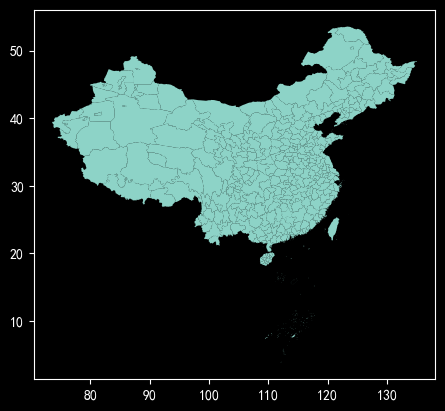

In [ ]:
####### 判断区域的省份信息 #########
import geopandas as gpd

shapefile_path = "D:/4.Intern/2.Zhihui_Lvxing/2.OBD/中国各级行政区边界（shp格式）/行政边界_市级.shp"
gdf = gpd.read_file(shapefile_path)

print(gdf.head())

city_geometry = gdf.geometry[0]  # 第一个城市的几何信息
print(city_geometry)

# 查看某个城市的属性信息
city_attributes = gdf.iloc[0]  # 第一个城市的属性信息
print(city_attributes)

import matplotlib.pyplot as plt
gdf.plot()
plt.show()

In [ ]:
########### 将OD划分为在市区内还是跨市-step1 ###############
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# 读取车辆路程数据
car_routes_path = "D:/4.Intern/2.Zhihui_Lvxing/2.OBD/0717_driving_results1.xlsx"  # 替换为你的 Excel 文件路径
df = pd.read_excel(car_routes_path)

# 读取城市边界数据
cities_path = "D:/4.Intern/2.Zhihui_Lvxing/2.OBD/中国各级行政区边界（shp格式）/行政边界_市级.shp"  # 替换为你的 Shapefile 文件路径
cities_gdf = gpd.read_file(cities_path)

# 确保城市边界数据的坐标系是 WGS84 (EPSG:4326)
if cities_gdf.crs != "EPSG:4326":
    cities_gdf = cities_gdf.to_crs(epsg=4326)

# 将起始点和结束点转换为 GeoDataFrame
geometry_start = [Point(xy) for xy in zip(df["起始经度"], df["起始纬度"])]
geometry_end = [Point(xy) for xy in zip(df["终止经度"], df["终止纬度"])]
gdf_start = gpd.GeoDataFrame(df, geometry=geometry_start, crs="EPSG:4326")
gdf_end = gpd.GeoDataFrame(df, geometry=geometry_end, crs="EPSG:4326")

# 空间连接：判断起始点和结束点位于哪个城市
start_cities = gpd.sjoin(gdf_start, cities_gdf, how="left", predicate="within")
end_cities = gpd.sjoin(gdf_end, cities_gdf, how="left", predicate="within")

# 提取城市名称
df["起始点城市"] = start_cities["City"]  # 假设城市名称在 '城市名称' 列
df["结束点城市"] = end_cities["City"]

# 保存结果
output_path = "D:/4.Intern/2.Zhihui_Lvxing/2.OBD/0717_driving_results1_with_cities.xlsx"
df.to_excel(output_path, index=False)

print(f"处理完成，结果已保存到 {output_path}")

处理完成，结果已保存到 D:/4.Intern/2.Zhihui_Lvxing/2.OBD/0717_driving_results1_with_cities.xlsx


In [ ]:
######## 里程差分类 ###############
import pandas as pd

df = pd.read_excel("D:/4.Intern/2.Zhihui_Lvxing/2.OBD/0717_driving_results1_with_cities.xlsx")

def classify_distance(distance):
    if distance <= 20:
        return "短途"
    elif 20 < distance <=50:
        return "中短途"
    elif 50 < distance <= 100:
        return "中途"
    elif 100 < distance <= 200:
        return "中长途"
    else:
        return "长途"

df['里程差分类'] = df['里程差'].apply(classify_distance)

df.to_excel("D:/4.Intern/2.Zhihui_Lvxing/2.OBD/0717_driving_results1_with_cities_classified.xlsx")

In [ ]:
######### 市内 / 跨市分类 - step2 #########
df = pd.read_excel("D:/4.Intern/2.Zhihui_Lvxing/2.OBD/0717_driving_results1_with_cities_classified.xlsx")

def classify_city(start_city, end_city):
    if start_city == end_city:
        return "市内"
    else:
        return "跨市"

df['运行类型'] = df.apply(lambda row: classify_city(row['起始点城市'], row['结束点城市']), axis = 1)

df.to_excel("D:/4.Intern/2.Zhihui_Lvxing/2.OBD/0717_driving_results1_with_cities_classified_city.xlsx", index=False)